In [1]:
import numpy as np
import matplotlib.pyplot as plt

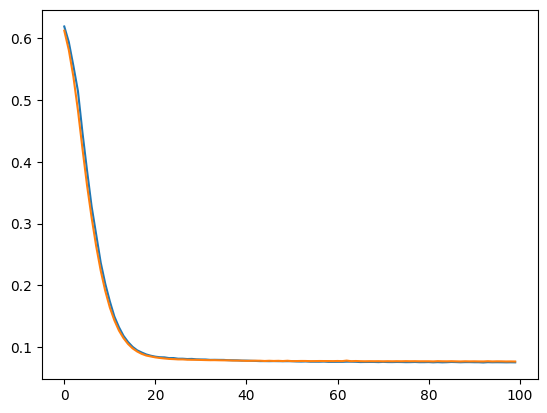

In [2]:
train_loss_curve = np.load("./ckpt/train_loss_curve.npy")
test_loss_curve = np.load("./ckpt/test_loss_curve.npy")

plt.plot(train_loss_curve, label="train")
plt.plot(test_loss_curve, label="test")

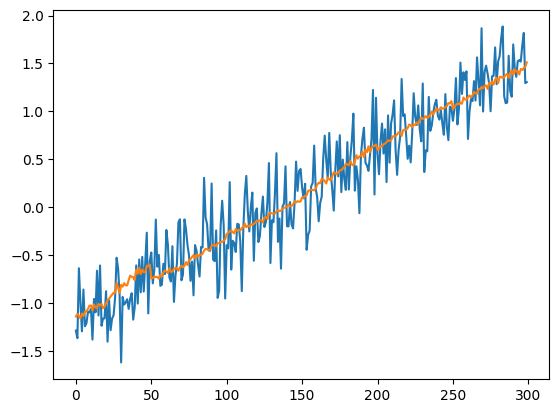

In [3]:
y = np.load("./ckpt/y.npy")
y_ = np.load("./ckpt/y_.npy")

plt.plot(y, label="y")
plt.plot(y_, label="y_")    

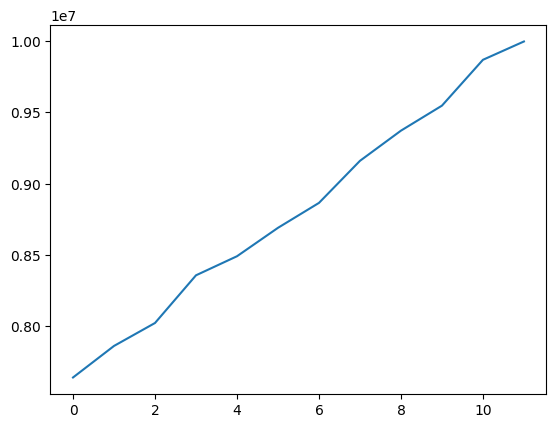

In [4]:
month_count = np.load("./data/month_count.npy")
month_day_count = np.load("./data/month_day_count.npy")
day_average = month_count/month_day_count
plt.plot(day_average, label="month_count")

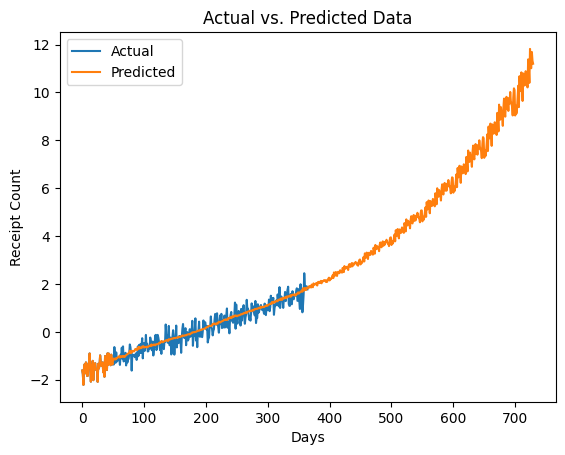

In [5]:
import torch
import torch.nn as nn
import numpy as np
from utils import MyLSTM

# load the model
in_window, out_window = 50, 50
model_type = "Linear"
if model_type == "LSTM":
    model = MyLSTM(in_dim=1, hidden_size=128, out_size=out_window, num_layers=3)
elif model_type == "Linear":
    model = nn.Sequential(
        nn.Linear(in_window, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, out_window)
    )
else:
    raise ValueError("Invalid model type!")   
model.load_state_dict(torch.load(f'./ckpt/{model_type}.pt'))
model = model.double()

# load the data
original_data = np.load('data/time_series_data.npy')
time_series_data = np.zeros(365*2, dtype=np.float64)
time_series_data[:in_window] = original_data[:in_window]

# run the inference
model.eval()
for index in range(in_window, 365*2, out_window):
    if model_type == "LSTM":
        data = torch.tensor(time_series_data[index-in_window: index]).to(torch.float64).view(1, -1, 1)
    elif model_type == "Linear":
        data = torch.tensor(time_series_data[index-in_window: index]).to(torch.float64).view(1, -1)
    with torch.no_grad():
        predicted = model(data)
        if index + out_window > 365*2:
            time_series_data[index:] = predicted[0].numpy()[:365*2-index]
        else:
            time_series_data[index : index + out_window] = predicted[0].numpy()

plt.plot(original_data, label="Actual")
plt.plot(time_series_data, label="Predicted")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Receipt Count")
plt.title("Actual vs. Predicted Data")
plt.show()